In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')
import bs4
from bs4 import BeautifulSoup
import requests
import re
import json
from __future__ import division
from difflib import get_close_matches
from datetime import date
import datetime
from datetime import datetime
import seaborn as sns
import pickle

In [2]:
with open('sub.pkl', 'r') as picklefile:
    sub = pickle.load(picklefile)

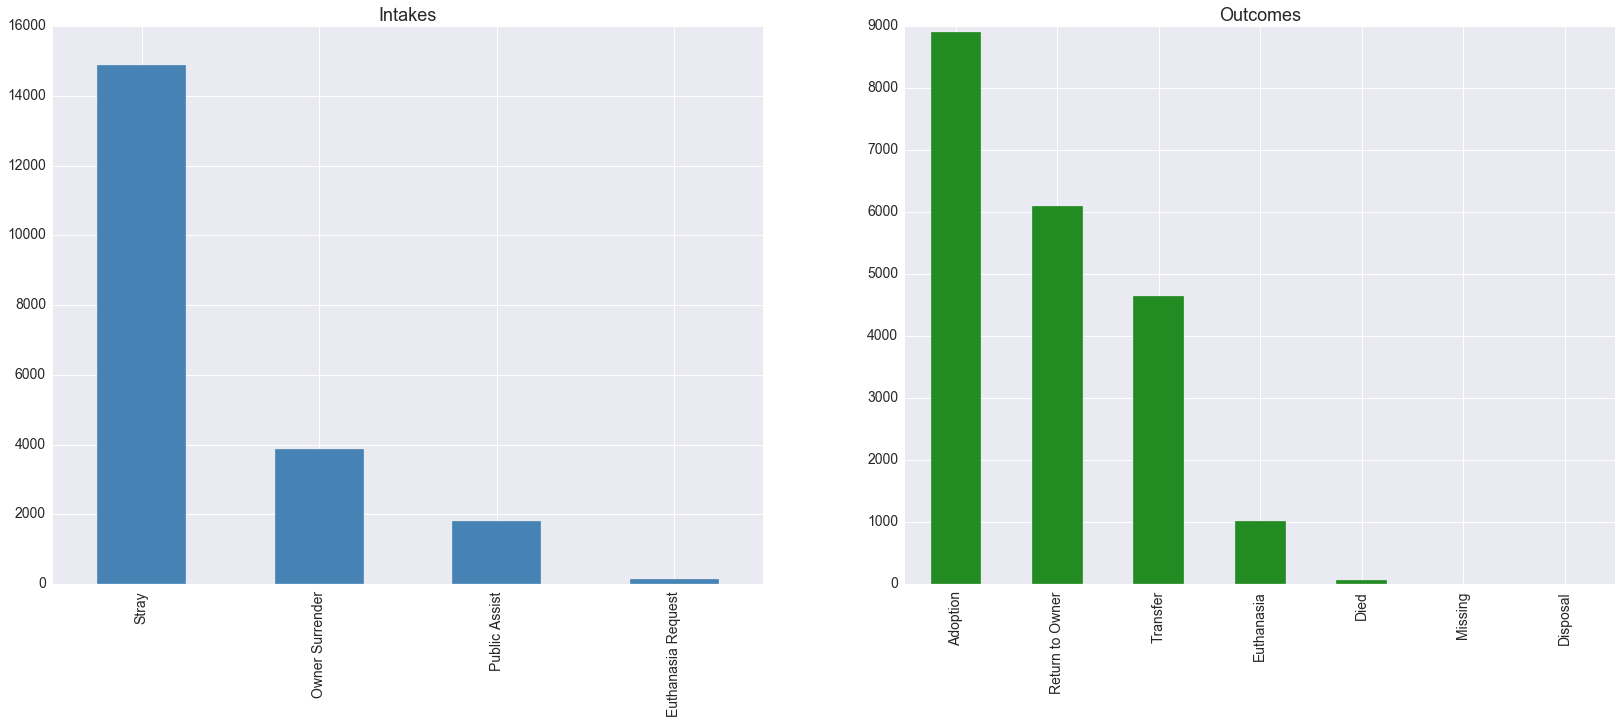

In [3]:
# intake and outcome types for all dogs in the data
fig, ax = plt.subplots(1,2, figsize=(28,10))
sub["in_type"].value_counts().plot(kind="bar", ax=ax[0], color="steelblue")
ax[0].set_title("Intakes", fontsize="18")

ax[0].tick_params(axis='both', which='major', labelsize=14)
sub["outcome"].value_counts().plot(kind="bar", ax=ax[1], color="forestgreen")
ax[1].set_title("Outcomes", fontsize="18")
ax[1].tick_params(axis='both', which='major', labelsize=14)

The majority of dogs come in as strays, and the most common outcome is adoption.


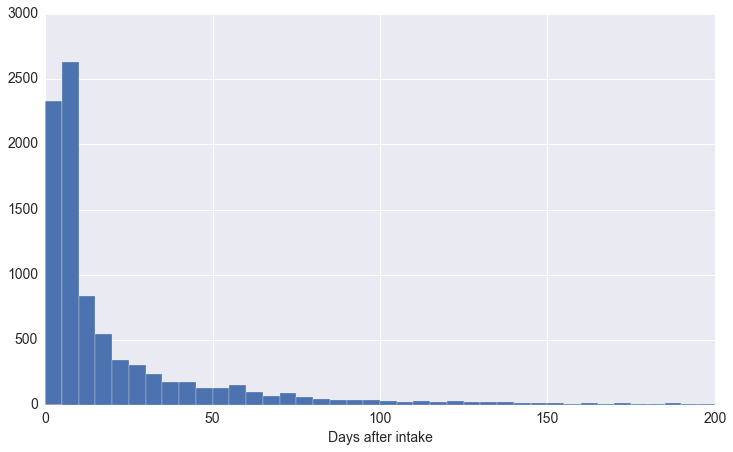

In [7]:
# look at shelter time for just dogs who were adopted
fig, ax = plt.subplots(figsize=(12,7))
adopt = sub[sub["outcome"]=="Adoption"]
bins = range(0,500,5)
adopt["shelter_time"].hist(ax=ax, bins=bins)
# plt.title("Time until adoption", fontsize=28)
ax.set(xlim=[0,200])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel("Days after intake", fontsize=14)

The majority of dogs were adopted within 2 weeks

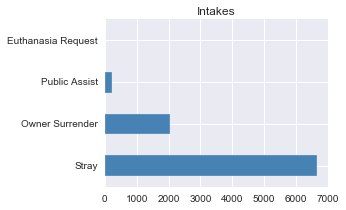

In [8]:
# look at income type just for the dogs who were adopted
fig, ax = plt.subplots(figsize=(4,3))
adopt["in_type"].value_counts().plot(kind="barh", color="steelblue")
ax.set_title("Intakes")

For dogs who are adopted, the most common intake circumstances was as a stray.

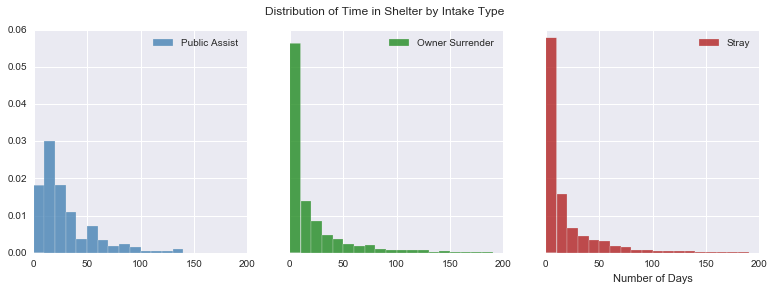

In [12]:
# excluding Euthanasia Request, for which there are so few dogs, plot the time in the shelter by intake type
cols = ["steelblue","forestgreen","firebrick","gold"]
bins = range(0,200,10)
fig, ax = plt.subplots(1,3,figsize=(13,4), sharey=True)
intakes = ["Public Assist","Owner Surrender","Stray"]
for col, intake, ax in zip(cols, intakes, ax):
    adopt[adopt["in_type"]==intake]["shelter_time"].hist(bins=bins, ax=ax, color=col, alpha=0.8,normed=True, label=intake)
    ax.set(xlim=[0,200])
    ax.legend()

plt.xlabel("Number of Days")
plt.suptitle("Distribution of Time in Shelter by Intake Type")

Dogs who come is as strays or surrendered by their owners appear to be adopted more quickly than those that come in under the public assistance program.

/Users/pt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
/Users/pt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()


[(735234.0, 735963.0)]

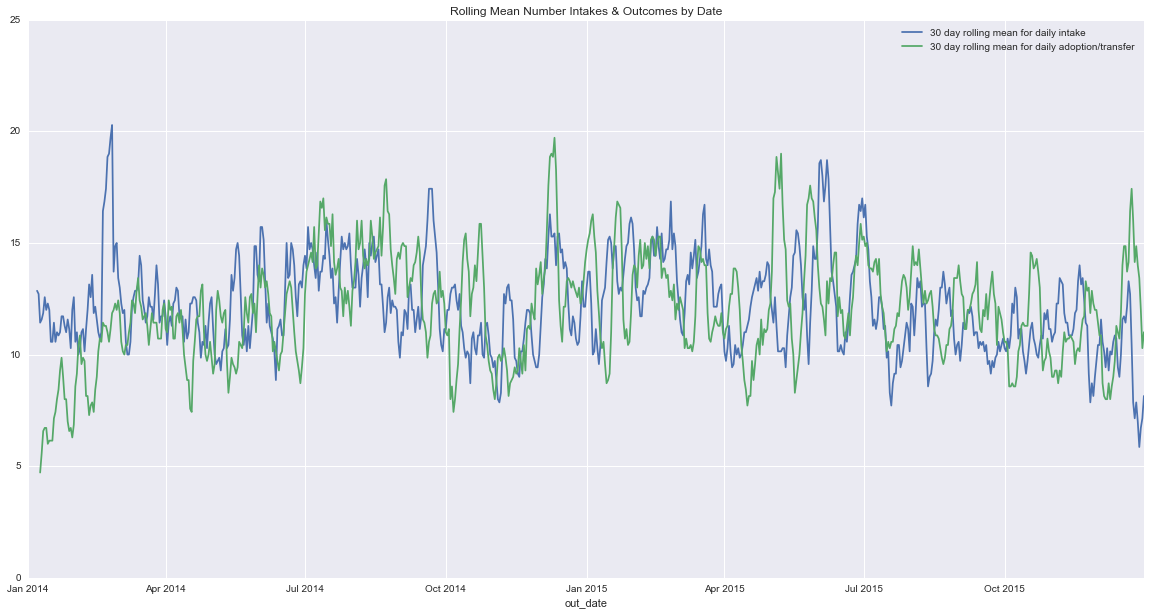

In [13]:
# examine number of intakes / adoptions over time to look for time trends
start_date = pd.to_datetime("1/1/2014").date()
end_date = pd.to_datetime("12/31/2015").date()
fig, ax = plt.subplots(figsize=(20,10))
pd.rolling_mean(pd.pivot_table(adopt,index="in_date",values="colour",aggfunc=len),7)\
.plot(label ="30 day rolling mean for daily intake")
pd.rolling_mean(pd.pivot_table(adopt,index="out_date",values="colour",aggfunc=len),7)\
.plot(label ="30 day rolling mean for daily adoption/transfer")
ax.set_title("Rolling Mean Number Intakes & Outcomes by Date")
ax.legend()
ax.set(xlim=[start_date,end_date])

There doesn't seem to be a clear trend over time.

/Users/pt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


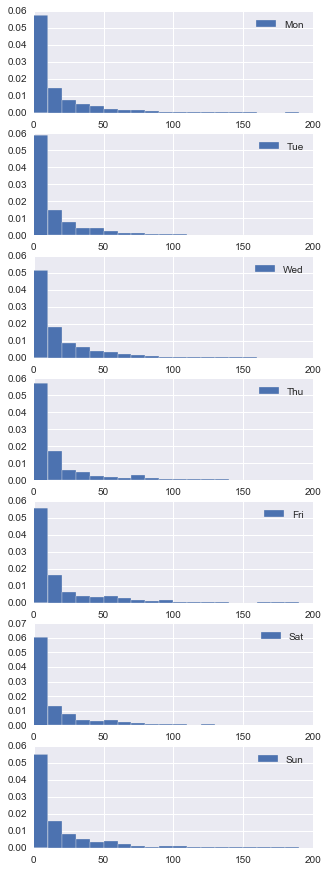

In [14]:
# check by day
adopt["day"] = adopt["in_date"].apply(lambda x: x.weekday())
days = range(0,7)
weekday = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
fig, ax = plt.subplots(7,1,figsize=(5,15))
for day, ax, wd in zip(days, ax, weekday):
    adopt[adopt["day"]==day]["shelter_time"].hist(bins=bins,ax=ax, normed=True, label=wd)
    ax.legend()

No clear evidence that day of week for intake has bearing on the length of time until adoption.

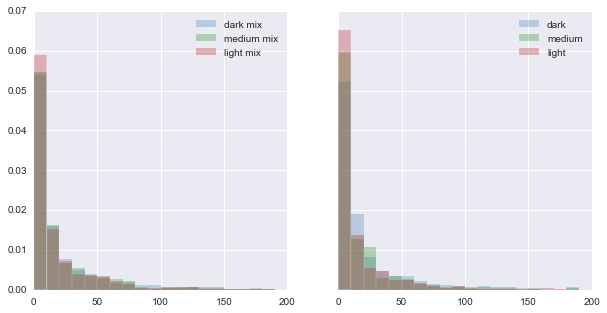

In [15]:
mixed = ["dark mix","medium mix","light mix"]
one = ["dark","medium","light"]
cols = ["steelblue","forestgreen","firebrick"]
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
for mix, col in zip(mixed,cols):
    adopt[adopt["colour"]==mix]["shelter_time"].hist(bins=bins,ax=ax[0], alpha=0.3, color=col, label=mix, normed=True)
ax[0].legend() 
for coat, col in zip(one,cols):
    adopt[adopt["colour"]==coat]["shelter_time"].hist(bins=bins,ax=ax[1], alpha=0.3, color=col, label=coat, normed=True)
ax[1].legend()

None mixed coats seem to be adopted more quickly, and lighter coats (both mixed and non) more quickly than darker coats.


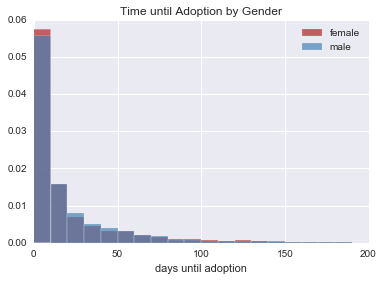

In [16]:
# plot distribution of time in shelter by gender
fig, ax = plt.subplots(figsize=(6,4))
adopt[adopt["in_sex"]==0]["shelter_time"].hist(bins=bins, ax=ax,label="female",color="firebrick", alpha=0.7, normed=True)
adopt[adopt["in_sex"]==1]["shelter_time"].hist(bins=bins, ax=ax,label="male",color="steelblue", alpha=0.7, normed=True)
plt.xlabel("days until adoption")
plt.title("Time until Adoption by Gender")
plt.legend()

Female dogs appear to be adopted at a slightly faster rate.

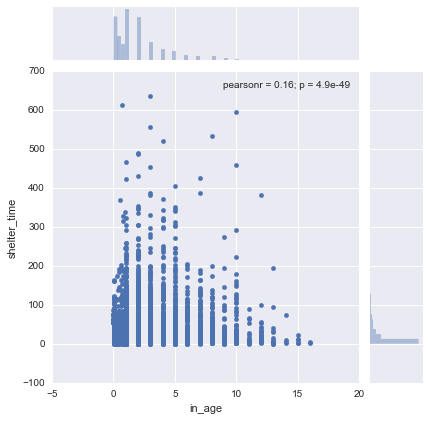

In [17]:
sns.jointplot(x="in_age",y="shelter_time", data=adopt)


The joint plot above suggests that the older a dog is on intake, the longer it takes to be adopted.

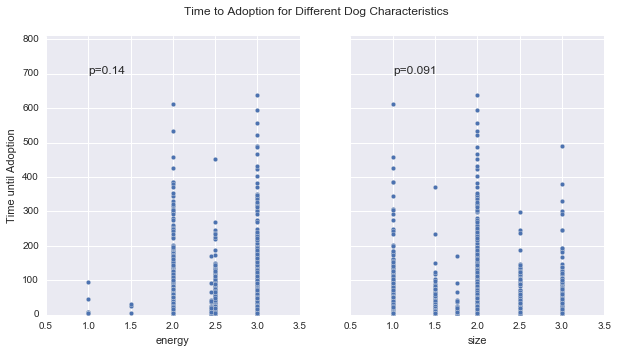

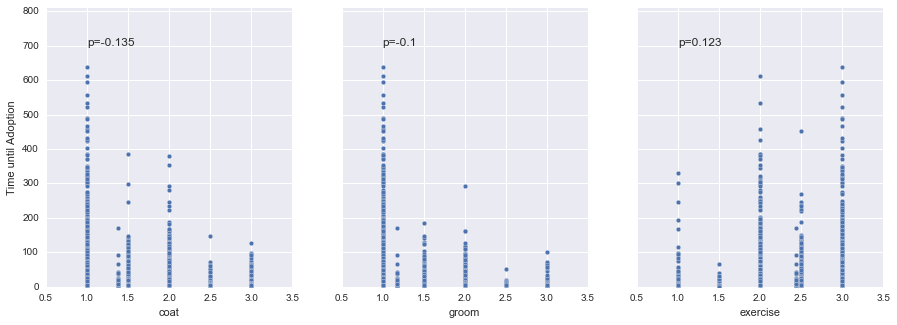

In [18]:
# energy / size vs adoption
fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
features = ["energy","size"]
for feature, ax in zip(features, ax):
    adopt.plot(x=feature,y="shelter_time", kind="scatter", ax=ax)
    ax.set(ylim=[0,810], ylabel="Time until Adoption")
    cor = "p={:0.2}".format(np.corrcoef(adopt["shelter_time"],adopt[feature])[0,1])
    ax.annotate(cor, xy=(1,700),xytext=(1, 700))
plt.suptitle("Time to Adoption for Different Dog Characteristics")

# coat, grooming, exercise
fig, ax = plt.subplots(1,3,figsize=(15,5), sharey=True)
features = ["coat","groom","exercise"]
for feature, ax in zip(features, ax):
    adopt.plot(x=feature,y="shelter_time", kind="scatter", ax=ax)
    ax.set(ylim=[0,810], ylabel="Time until Adoption")
    cor = "p={:0.3}".format(np.corrcoef(adopt["shelter_time"],adopt[feature])[0,1])
    ax.annotate(cor, xy=(1,700),xytext=(1, 700))

The above charts suggest the following relationships:
- 1) higher energy dogs, and those that need more exercise, take longer to be adopted
- 2) shorter haired dogs, and those that need less grooming, are adopted more slowly
- 3) larger dogs take longer to be adopted

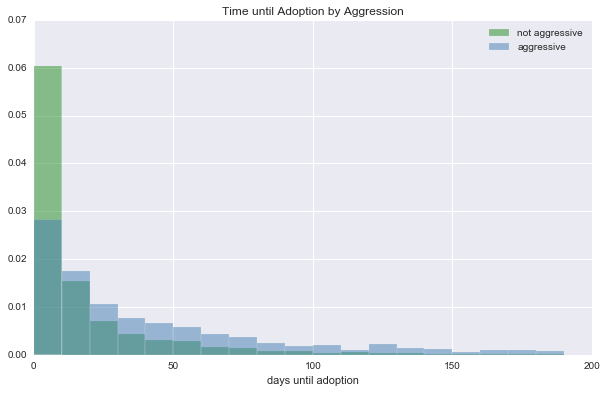

In [30]:
# plot distribution of time in shelter by aggression
aggression = (adopt["aggressive"]==1)
fig, ax = plt.subplots(figsize=(10,6))
adopt[~aggression]["shelter_time"].hist(bins=bins, ax=ax,label="not aggressive",color="forestgreen", alpha=0.5, normed=True)
adopt[aggression]["shelter_time"].hist(bins=bins, ax=ax,label="aggressive",color="steelblue", alpha=0.5, normed=True)
plt.xlabel("days until adoption")
plt.title("Time until Adoption by Aggression")
plt.legend()

Dogs who are breeds that are typically viewed of as aggressive (Pit Bulls and Staffordshire Terriers) take longer to be adopted

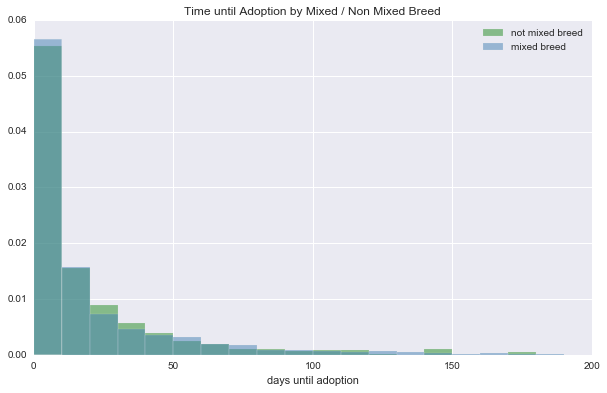

In [20]:
# plot distribution of time in shelter by mix breed or not
mix = (adopt["mix"]==1)
fig, ax = plt.subplots(figsize=(10,6))
adopt[~mix]["shelter_time"].hist(bins=bins, ax=ax,label="not mixed breed",color="forestgreen", alpha=0.5, normed=True)
adopt[mix]["shelter_time"].hist(bins=bins, ax=ax,label="mixed breed",color="steelblue", alpha=0.5, normed=True)
plt.xlabel("days until adoption")
plt.title("Time until Adoption by Mixed / Non Mixed Breed")
plt.legend()

Mixed breed dogs seem to get adopted at roughly the same rate as non mixed breeds.

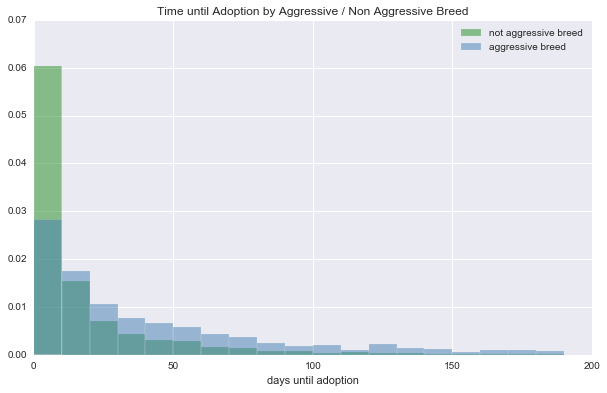

In [21]:
# plot distribution of time in shelter by aggressive or not
agg = (adopt["aggressive"]==1)
fig, ax = plt.subplots(figsize=(10,6))
adopt[~agg]["shelter_time"].hist(bins=bins, ax=ax,label="not aggressive breed",color="forestgreen", alpha=0.5, normed=True)
adopt[agg]["shelter_time"].hist(bins=bins, ax=ax,label="aggressive breed",color="steelblue", alpha=0.5, normed=True)
plt.xlabel("days until adoption")
plt.title("Time until Adoption by Aggressive / Non Aggressive Breed")
plt.legend()

In [22]:
akc_groups = ["other",'miscellaneous-class', 'herding', 'toy', 'working', 'sporting', 'non-sporting', 'hound', 'terrier']
for group in akc_groups:
    print "Average time to adoption for", group, "group is {:0.4} days".format(adopt[adopt[group]==1]["shelter_time"].mean())

Average time to adoption for other group is 44.04 days
Average time to adoption for miscellaneous-class group is 117.9 days
Average time to adoption for herding group is 19.91 days
Average time to adoption for toy group is 15.86 days
Average time to adoption for working group is 23.44 days
Average time to adoption for sporting group is 24.83 days
Average time to adoption for non-sporting group is 24.63 days
Average time to adoption for hound group is 18.39 days
Average time to adoption for terrier group is 22.85 days


There is some evidence that different breeds groups get adopted at different rates.

### Names

In [23]:
print "proportion of dogs missing name:",np.sum(adopt["missing_name"])/len(adopt)

proportion of dogs missing name: 0.14174997192


/Users/pt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()


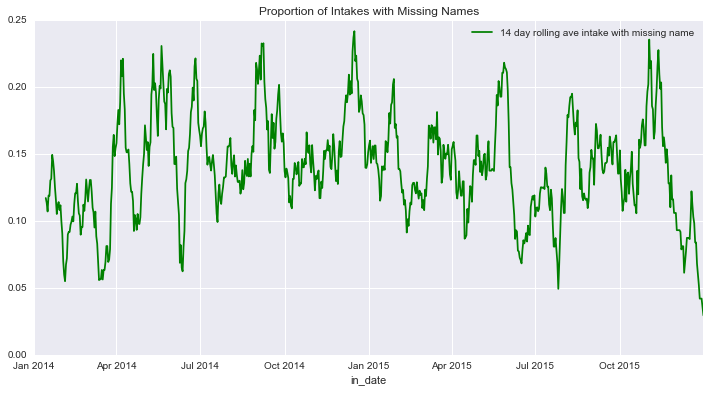

In [24]:
# check if missing name is a function of time - i.e. the shelter has not been consistently recording the names
# check if name missingness is function of time
fig, ax = plt.subplots(figsize=(12,6))



pd.rolling_mean((pd.pivot_table(adopt,index=["in_date"],values="missing_name", aggfunc=sum)/\
                 pd.pivot_table(adopt,index=["in_date"],values="missing_name", aggfunc=len)),14)\
.plot(ax=ax,color="green",\
            label="14 day rolling ave intake with missing name")
ax.legend()
plt.title("Proportion of Intakes with Missing Names")

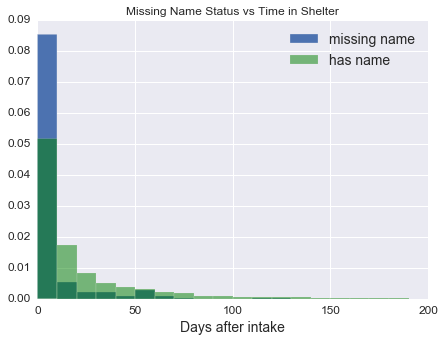

In [25]:
# check if missing name seems to affect outcome
fig, ax = plt.subplots(figsize=(7,5))
bins = range(0,200,10)
adopt[adopt["missing_name"]==1]["shelter_time"].hist(bins=bins, normed=True,label="missing name")
adopt[adopt["missing_name"]==0]["shelter_time"].hist(bins=bins, normed=True,label="has name", color="green", alpha=0.5)
ax.set(xlim=[0,200])
ax.set_xlabel("Days after intake", fontsize=14)
ax.legend(prop={'size':14})
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title("Missing Name Status vs Time in Shelter")

Dogs with missing names appear to get adopted more quickly. This may be because dogs that arrive with no names (for example as strays, or dropped off with no information), that are also adopted quickly, may never be named by the shelter. In this case, the fact that the name is missing may be a function of the outcome (i.e. the time the dog is in the shelter).<br>
There are a number of dogs with missing names, however, that remain in the shelter for a long time (the longest is about five months). For those cases, it's reasonable to assume that the fact that the name is missing is possibly random (i.e., poor record keeping by the shelter).<br>
Since it's unclear what the cause of the missingness is, and since it may be a function of the outcome, rather than a predictor of the outcome, this study will only look at dogs who are named. It should be noted, however, that this limits the generalizability of findings, the effect of not having a name cannot be investigated, and excluding those dogs with missing names may bias the findings in other ways (for example, if missing name is correlated with some other feature).

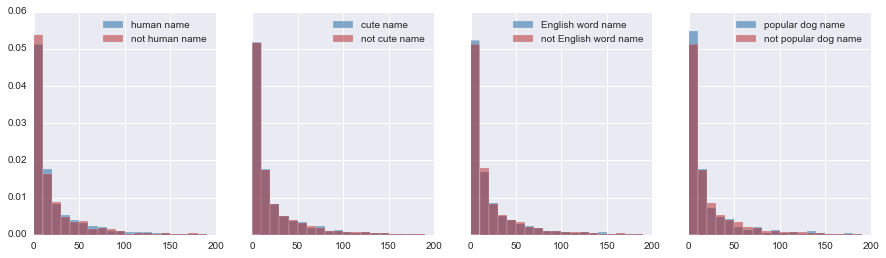

In [26]:
#plot distribution of outcome by different name groups
temp = adopt[adopt["missing_name"]==0]
human = (temp["human_name"]==1)
cute = (temp["cute_name"]==1)
word = (temp["word_name"]==1)
dog = (temp["popular_dog_name"]==1)

fig, ax = plt.subplots(1,4,figsize=(15,4), sharey=True)
temp[human]["shelter_time"].hist(bins=bins, ax=ax[0], alpha=0.65, color="steelblue", label="human name", normed=True)
temp[~human]["shelter_time"].hist(bins=bins, ax=ax[0], alpha=0.5, color="firebrick", label="not human name", normed=True)
ax[0].legend()

temp[cute]["shelter_time"].hist(bins=bins, ax=ax[1], alpha=0.65, color="steelblue", label="cute name", normed=True)
temp[~cute]["shelter_time"].hist(bins=bins, ax=ax[1], alpha=0.5, color="firebrick", label="not cute name", normed=True)
ax[1].legend()

temp[word]["shelter_time"].hist(bins=bins, ax=ax[2], alpha=0.65, color="steelblue", label="English word name", normed=True)
temp[~word]["shelter_time"].hist(bins=bins, ax=ax[2], alpha=0.5, color="firebrick", label="not English word name", normed=True)
ax[2].legend()

temp[dog]["shelter_time"].hist(bins=bins, ax=ax[3], alpha=0.65, color="steelblue", label="popular dog name", normed=True)
temp[~dog]["shelter_time"].hist(bins=bins, ax=ax[3], alpha=0.5, color="firebrick", label="not popular dog name", normed=True)
ax[3].legend()

Overall there seems to be only small differences.
- Dogs with non-human names appear to be adopted slightly more quickly
- Dogs with English word names appear to be adopted slightly more quickly
- Dogs with popular dog names are adopted slightly more quickly
- There is little evidence for a difference between dogs with cute names and not cute names
- These differences may be more pronounced, however, for different types of groups.

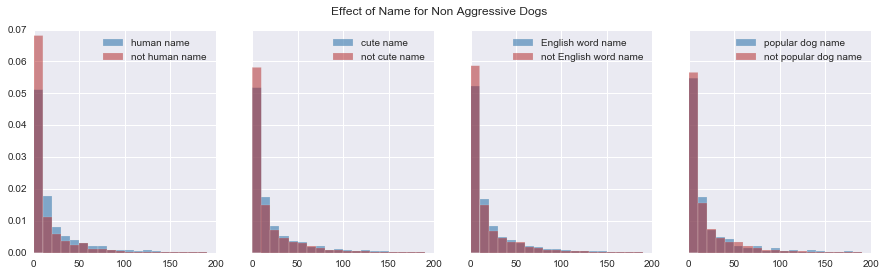

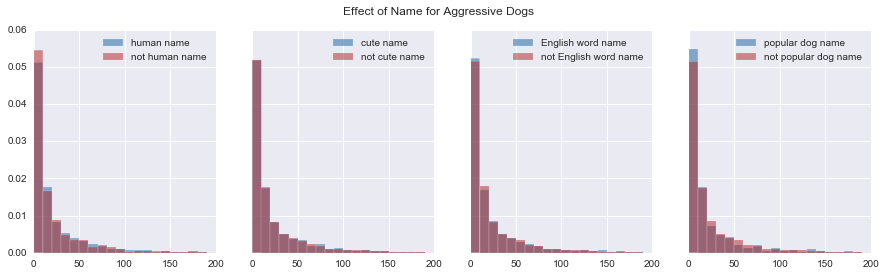

In [28]:
#check for differences in impact of name between aggressive and non-aggressive type dogs
temp = adopt[(adopt["aggressive"]==0)|(adopt["missing_name"]==0)]
def print_charts(temp):
    human = (temp["human_name"]==1)
    cute = (temp["cute_name"]==1)
    word = (temp["word_name"]==1)
    dog = (temp["popular_dog_name"]==1)

    fig, ax = plt.subplots(1,4,figsize=(15,4), sharey=True)
    temp[human]["shelter_time"].hist(bins=bins, ax=ax[0], alpha=0.65, color="steelblue", label="human name", normed=True)
    temp[~human]["shelter_time"].hist(bins=bins, ax=ax[0], alpha=0.5, color="firebrick", label="not human name", normed=True)
    ax[0].legend()

    temp[cute]["shelter_time"].hist(bins=bins, ax=ax[1], alpha=0.65, color="steelblue", label="cute name", normed=True)
    temp[~cute]["shelter_time"].hist(bins=bins, ax=ax[1], alpha=0.5, color="firebrick", label="not cute name", normed=True)
    ax[1].legend()

    temp[word]["shelter_time"].hist(bins=bins, ax=ax[2], alpha=0.65, color="steelblue", label="English word name", normed=True)
    temp[~word]["shelter_time"].hist(bins=bins, ax=ax[2], alpha=0.5, color="firebrick", label="not English word name", normed=True)
    ax[2].legend()

    temp[dog]["shelter_time"].hist(bins=bins, ax=ax[3], alpha=0.65, color="steelblue", label="popular dog name", normed=True)
    temp[~dog]["shelter_time"].hist(bins=bins, ax=ax[3], alpha=0.5, color="firebrick", label="not popular dog name", normed=True)
    ax[3].legend()

print_charts(temp)
plt.suptitle("Effect of Name for Non Aggressive Dogs")

temp = adopt[(adopt["aggressive"]==1)|(adopt["missing_name"]==0)]
print_charts(temp)
plt.suptitle("Effect of Name for Aggressive Dogs")

The above charts clearly suggest that the effect of name depends on whether the dog is an aggressive breed or not. For non aggressive dogs, having a human's name, a cute name and a name that is an English word appears to shorten time to adoption. For aggressive dogs, only have a human name and popular dog name appear to have an effect, and it is much less pronounced.
These types of interaction will be incorporated into the model building and formal technical analysis.